# Medchem Query Language

The Medchem query language is a simple and intuitive language allowing to express a filtering procedure based on the Medchem API. It's particularly convenient in contexts outside of Python. For example, you can build a frontend application to filter compounds while giving the user full flexibility how to input a filtering procedure. It's also an efficient way to serialize a filtering process and share it with other people using Medchem. 

The query language is based on [`lark`](https://lark-parser.readthedocs.io/en/latest/).

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import datamol as dm
import pandas as pd

import medchem as mc

We start by providing some simple example for building a query. Then we provide the grammar and syntax used by the medchem query language.

### Example #1

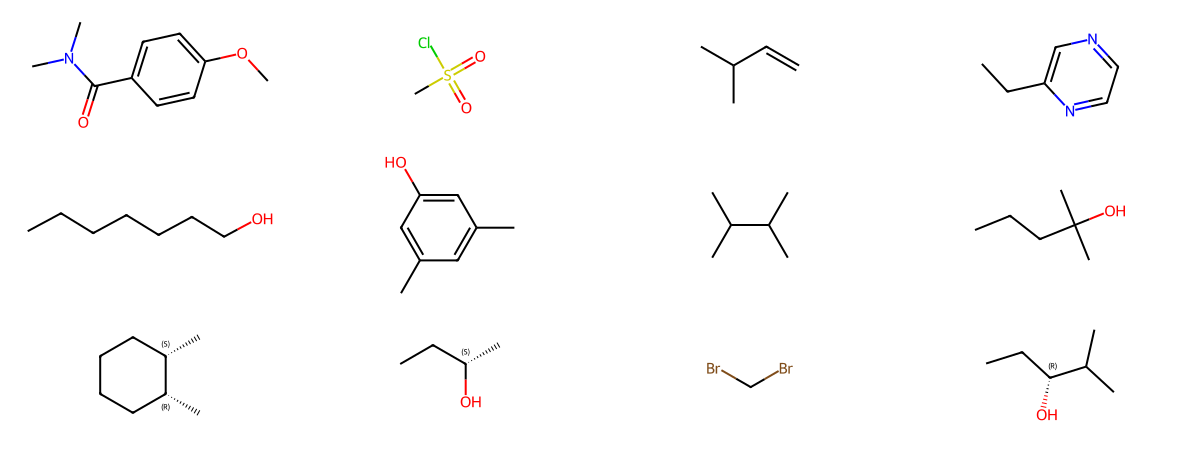

In [2]:
# note that whitespace and newlines are ignored in the query
query = """
(
    HASPROP("n_lipinski_hba" < 3) AND ! HASALERT("pains")
) 
    OR 
(
    HASGROUP("Alcohols") 
    OR 
    HASSUBSTRUCTURE("[CX3](=[OX1])O", True, 1)
)
"""

data = dm.freesolv()
data = data.iloc[:12]

data["mol"] = data["smiles"].apply(dm.to_mol)

dm.to_image(data["mol"].tolist(), n_cols=4, mol_size=(300, 150))

In [3]:
query_filter = mc.query.QueryFilter(query)
out = query_filter(data["smiles"], n_jobs=-1, progress=True)

out

Loading Mols:   0%|          | 0/12 [00:00<?, ?it/s]

[False, True, True, True, True, True, True, True, True, True, True, True]

### Example #2

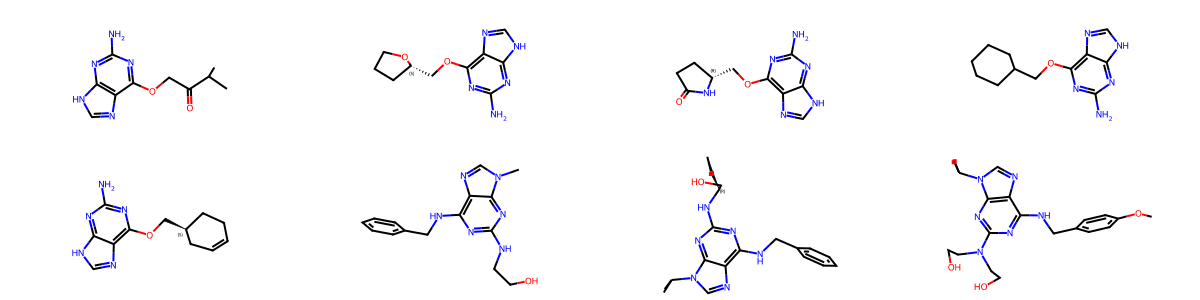

In [4]:
data = dm.data.cdk2()
data = data.iloc[:8]

dm.to_image(data["mol"].apply(dm.sanitize_mol).tolist(), n_cols=4, mol_size=(300, 150))

In [5]:
query = """HASPROP("tpsa" < 120) AND HASSUBSTRUCTURE("[OH]", True)"""
chemical_filter = mc.query.QueryFilter(query, parser="lalr")

chemical_filter

((`fn(getprop, prop='tpsa')` < 120.0) and `fn(hassubstructure, query='[OH]', is_smarts=True, operator=None, limit=None)`)

In [6]:
out = chemical_filter(data["mol"], n_jobs=1)

out

Loading Mols:   0%|          | 0/8 [00:00<?, ?it/s]

[False, False, False, False, False, True, True, True]

---

## Syntax

The medchem query syntax enables orchestrating a list of expressions into statements using predefined function operators, boolean operators, and comparators.

1. The syntax enforces some basic rules for clarity and to simplify parsing. For instance, any string provided as `query` argument needs to be quoted (similar to json) to avoid ambiguity in parsing.

    An example of valid query is:

    ```diff
    + """(HASPROP("tpsa" > 120 ) | HASSUBSTRUCTURE("c1ccccc1")) AND NOT HASALERT("pains") OR HASSUBSTRUCTURE("[OH]", max, 2)"""
    ```

    Examples of invalid queries are:

    ```diff
    - """HASPROP("tpsa" > 120) OR HASSUBSTRUCTURE("[OH]", True, >, 3)""" : unexpected wrong operator '>'
    - """HASPROP(tpsa > 120)""" : tpsa is not quoted
    - """HASPROP("tpsa") > 120""" : this is not part of the language specification
    - """(HASPROP("tpsa" > 120) AND HASSUBSTRUCTURE("[OH]", True, max, 3 )""" : mismatching parenthesis '('
    ```

1. The syntax follows standard rules for grouping expressions. Using parentheses around an expression allows for defining complex statements and specifying evaluation priority.


    For example, the following statements are all equivalent:

    - `"""HASPROP("tpsa" > 120) OR HASSUBSTRUCTURE("CO")"""`
    - `"""(HASPROP("tpsa" > 120)) OR (HASSUBSTRUCTURE("CO"))"""`
    - `"""(HASPROP("tpsa" > 120) OR HASSUBSTRUCTURE("CO"))"""`




## Expressions

The query language supports the following expressions (function operators):


### `HASALERT`

Check whether a molecule has an `alert` from a catalog provided in medchem

```python
# alert is one supported alert catalog by `medchem`. For example `pains`
HASALERT(alert:str)
```

### `HASGROUP`

Check whether a molecule has a specific functional group provided in medchem

```python
# group is one supported functional group provided by `medchem`. For example `Alcohols`
HASGROUP(group:str)
```

### `MATCHRULE`

Check whether a molecule match a predefined druglikeness `rule` in medchem

```python
# rule is one supported rule provided by `medchem`. For example `rule_of_five`
MATCHRULE(rule:str)
```

### `HASSUPERSTRUCTURE`

Check whether a molecule has `query` as superstructure

```python
# query is required to be a SMILES
HASSUPERSTRUCTURE(query:str)
```

### `HASSUBSTRUCTURE`

Check whether a molecule has `query` as substructure.

Here, providing the comma separator `,` is _mandatory_ since each input variable is an argument to the `HASSUBSTRUCTURE` function.

```python
# query is a SMILES or a SMARTS, operator is defined below, is_smarts is a boolean
HASSUBSTRUCTURE(query:str, is_smarts:Optional[bool], operator:Optional[str], limit:Optional[int])

# which correspond to setting this default values
HASSUBSTRUCTURE(query:str, is_smarts=False, operator="min", limit=1)

# same as
HASSUBSTRUCTURE(query:str, is_smarts=None, operator=None, limit=None)
```

It is allowed to omit optional arguments, but they must be provided in the exact same order shown above. The following are all valid and equivalent (given their default values):

- `HASSUBSTRUCTURE("CO")`
- `HASSUBSTRUCTURE("CO", False)`
- `HASSUBSTRUCTURE("CO", False, min)`
- `HASSUBSTRUCTURE("CO", False, min, 1)`


Furthermore, since the correct argument map can be inferred when no ambiguity arises, the following examples `are valid but discouraged`

- `HASSUBSTRUCTURE("CO", False, 1)`
- `HASSUBSTRUCTURE("CO", min, 1)`

Whereas, this example is invalid:

- `HASSUBSTRUCTURE("CO", min, False, 1)`

### `HASPROP`

Check whether a molecule has `prop` as property within a defined limit.

**Any comma `,` provided between arguments will be ignored**

```python
# prop is a valid datamol.descriptors property, comparator is a required comparator operator (see) below
HASPROP(prop:str comparator:str limit:float)

# the following is equivalent
HASPROP(prop:str, comparator:str, limit:float)
```

### `LIKE`

Check whether a molecule is similar enough to another molecule.

**Any comma `,` provided between arguments will be ignored**

```python
# query is a SMILES
LIKE(query:str  comparator:str limit:float)

# the following is equivalent
LIKE(query:str, comparator:str, limit:float)
```

### Basic operators:

- comparator: one of `=` `==`, `!=`, `<`, `>`, `<=`, `>=`
- misc: the following misc values are accepted and parsed `true`, `false`, `True`, `False`, `TRUE`, `FALSE`
- operator (can be quoted or unquoted):
  - MIN: `min`, `MIN`
  - MAX: `max`, `MAX`
- boolean operator:
  - AND operator : `AND` or `&` or `&&` or `and`
  - OR operator : `OR` or `|` or `||` or `or`
  - NOT operator : `NOT` or `!` or `~` or `not`


---

-- The End :-)